## Compare metagene profiles of decapping factors on stable/unstable transcripts

In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import glob
import itertools
import seaborn as sns

#### set directories

In [2]:
home_dir = '/home/salma/Coding/scratch/'
pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/half_life_analysis')

In [3]:
factors = ['Dcp2', 'Dcp1', 'Edc2', 'Edc3', 'Dhh1']  #CHOOSE FACTORS OF INTEREST

stable_filename   =   'stable_orf_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'
unstable_filename = 'unstable_orf_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'


#### mockinbird postprocessing pipeline was used to generate metagene prodiles on stable and unstable genes 

In [4]:
#read profiles from mockinbird output and normalize them 

#stable transcripts
stable_profiles = list()
for fac in factors:
    with open(os.path.join(pipeline_dir,fac,'postprocess','TIF_HL',stable_filename)) as f:
        stable_profiles.append([float(i) for i in f.readlines()[0].split()])
        
stable_profiles = pd.DataFrame(stable_profiles, index=factors)        


#unstable transcripts
unstable_profiles = list()
for fac in factors:
    with open(os.path.join(pipeline_dir,fac,'postprocess','TIF_HL',unstable_filename)) as f:
        unstable_profiles.append([float(i) for i in f.readlines()[0].split()])
        
unstable_profiles = pd.DataFrame(unstable_profiles, index=factors)        

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [6]:
def plot_profile(stable_profiles, unstable_profiles, plot_name, labels, col = ['darkblue', 'teal']):
    
    f,axes = plt.subplots(len(factors),2 ,sharey='row',sharex='col' ,facecolor='w', figsize=(3,1.4*(len(factors))))
    plt.subplots_adjust(hspace = 0.0, wspace=0.05)

    
    for i in range(len(factors)):

        stab5 = running_mean(stable_profiles.iloc[i,vlinepos[1]-interval:vlinepos[1]+interval].values, sm)
        stab3 = running_mean(stable_profiles.iloc[i,vlinepos[3]-interval:vlinepos[3]+interval].values, sm) 
        
        unstab5 = running_mean(unstable_profiles.iloc[i,vlinepos[1]-interval:vlinepos[1]+interval].values, sm)
        unstab3 = running_mean(unstable_profiles.iloc[i,vlinepos[3]-interval:vlinepos[3]+interval].values, sm)

        x5 = np.arange(vlinepos[1]-interval+int(sm/2),vlinepos[1]+interval-int(sm/2)+1,1)
        x3 = np.arange(vlinepos[3]-interval+int(sm/2),vlinepos[3]+interval-int(sm/2)+1,1)

        # plot the same data on both axes
        ax1 = axes[i][0]
        ax2 = axes[i][1]
        
        kw = dict(linewidth=1.3)
        sl = ax1.plot(x5, unstab5, color = col[1], label='unstable transcripts', **kw)
        ul = ax1.plot(x5, stab5, color = col[0], ls='-', label='stable transcripts', **kw)
        
        ax2.plot(x3, unstab3, color = col[1], label='unstable transcripts', **kw)
        ax2.plot(x3, stab3, color = col[0], ls='-', label='stable transcripts', **kw)

        ax1.set_xlim(vlinepos[1]-interval,vlinepos[1]+interval)
        ax2.set_xlim(vlinepos[3]-interval,vlinepos[3]+interval)

        ax1.set_xticks([vlinepos[1] - tick, vlinepos[1], vlinepos[1] + tick])
        ax2.set_xticks([vlinepos[3] - tick, vlinepos[3], vlinepos[3] + tick])

        ax1.set_xticklabels(['-'+str(tick), labels[1], '+'+str(tick)])
        ax2.set_xticklabels(['-'+str(tick), labels[3], '+'+str(tick)])
        
        if i is 0:
            ax1.tick_params(top=True, labeltop=True)
            ax2.tick_params(top=True, labeltop=True)

        # hide the spines between ax1 and ax2
        ax1.spines['right'].set_linestyle((0,(4,6)))
        ax1.spines['right'].set_color('grey')
        
        ax2.spines['left' ].set_linestyle((0,(4,6)))
        ax2.spines['left' ].set_color('grey')
               
        ax1.tick_params(labelright='off')
        ax1.tick_params(labelleft='off')
        ax2.tick_params(labelright='off')
        ax2.tick_params(labelleft='off')
        

        d = .025 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=0.8)
        ax1.plot((1-d,1+d), (-d,+d), **kwargs)
        ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
        
        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d,+d), (1-d,1+d), **kwargs)
        ax2.plot((-d,+d), (-d,+d), **kwargs)


        ax1.axvline(x=vlinepos[1], color = 'grey', linewidth = 0.8, ls = (0,(3,3)))
        ax2.axvline(x=vlinepos[3], color = 'grey', linewidth = 0.8, ls = (0,(3,3)))
        
        ax1.set_ylabel(stable_profiles.index.values[i], fontsize=11)
        ax1.set_yticks([], [])
        ax2.set_yticks([], [])
        ax1.get_yaxis().set_label_coords(-0.2,0.5)
        ax1.tick_params(labelsize = 7)
        ax1.xaxis.set_tick_params(labelsize=8)
        ax2.xaxis.set_tick_params(labelsize=8)
        #ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(True)
        ax1.spines['left'].set_visible(False)
        #ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax1.set_ylim(0, 1.2*(ax1.get_ylim()[1]))
        if i==0:
            lgd = ax2.legend(bbox_to_anchor=(1.2,1.8), frameon=False)
    
    plt.savefig(os.path.join(plotting_dir, plot_name), bbox_extra_artists=(lgd,), bbox_inches='tight')


In [7]:
vlinepos = [1, 1000, 1751, 2501, 3499]
labels_TIF = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']
interval = 750 #area to plot
tick = 450 #position of tick labels
sm = 10 #smoothing

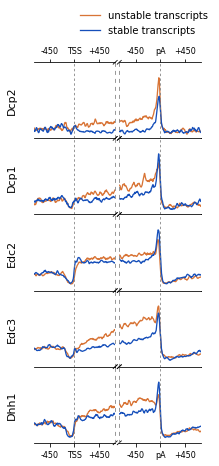

In [8]:
plot_profile(stable_profiles, unstable_profiles, plot_name='Decapping_by_halflife.pdf', labels=labels_TIF, 
             col=['#164fba', '#d87436'])